# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [35]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

g = torch.Generator()
g.manual_seed(seed)


# Data preparation

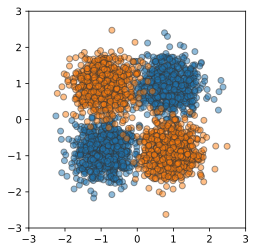

In [36]:
data_noise = 0.23
plotlim = [-3, 3]
subfolder = 'late_rob_xor'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('xor', noise = data_noise, plotlim = plotlim)


In [37]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-0.3713,  1.2212],
        [ 0.7906, -0.9382],
        [-0.4318,  1.0737],
        [ 1.1262,  1.1581],
        [-0.9578,  0.9549],
        [-0.9280, -1.0194],
        [ 1.6908, -1.3272],
        [ 0.7359,  0.7041],
        [ 1.7458, -1.1837],
        [-1.5882, -1.1365]]) tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0])


# Model dynamics

In [38]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5, 5 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

In [39]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [40]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
lnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_lnode = torch.optim.Adam(lnode.parameters(), lr=1e-3) 

# Training and generating level sets

In [41]:
from models.training import doublebackTrainer

num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent

num_epochs_stage1 = 40
num_epochs_stage2 = num_epochs - num_epochs_stage1

eps = 0.25 #0.25 worked


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 

   
trainer_anode.train(dataloader, num_epochs)

0.25

Iteration 0/45
Loss: 1.110
Robust Term Loss: 0.223
Accuracy: 0.547

Iteration 10/45
Loss: 1.228
Robust Term Loss: 0.221
Accuracy: 0.516

Iteration 20/45
Loss: 1.194
Robust Term Loss: 0.187
Accuracy: 0.562

Iteration 30/45
Loss: 1.055
Robust Term Loss: 0.198
Accuracy: 0.531

Iteration 40/45
Loss: 0.946
Robust Term Loss: 0.183
Accuracy: 0.531
Epoch 1: 1.144
0.25

Iteration 0/45
Loss: 0.913
Robust Term Loss: 0.170
Accuracy: 0.547

Iteration 10/45
Loss: 0.999
Robust Term Loss: 0.166
Accuracy: 0.516

Iteration 20/45
Loss: 1.003
Robust Term Loss: 0.147
Accuracy: 0.562

Iteration 30/45
Loss: 0.889
Robust Term Loss: 0.150
Accuracy: 0.531

Iteration 40/45
Loss: 0.849
Robust Term Loss: 0.134
Accuracy: 0.516
Epoch 2: 0.958
0.25

Iteration 0/45
Loss: 0.781
Robust Term Loss: 0.126
Accuracy: 0.547

Iteration 10/45
Loss: 0.840
Robust Term Loss: 0.122
Accuracy: 0.516

Iteration 20/45
Loss: 0.870
Robust Term Loss: 0.114
Accuracy: 0.547

Iteration 30/45
Loss: 0.778
Robust Term Loss: 0.115
Accuracy

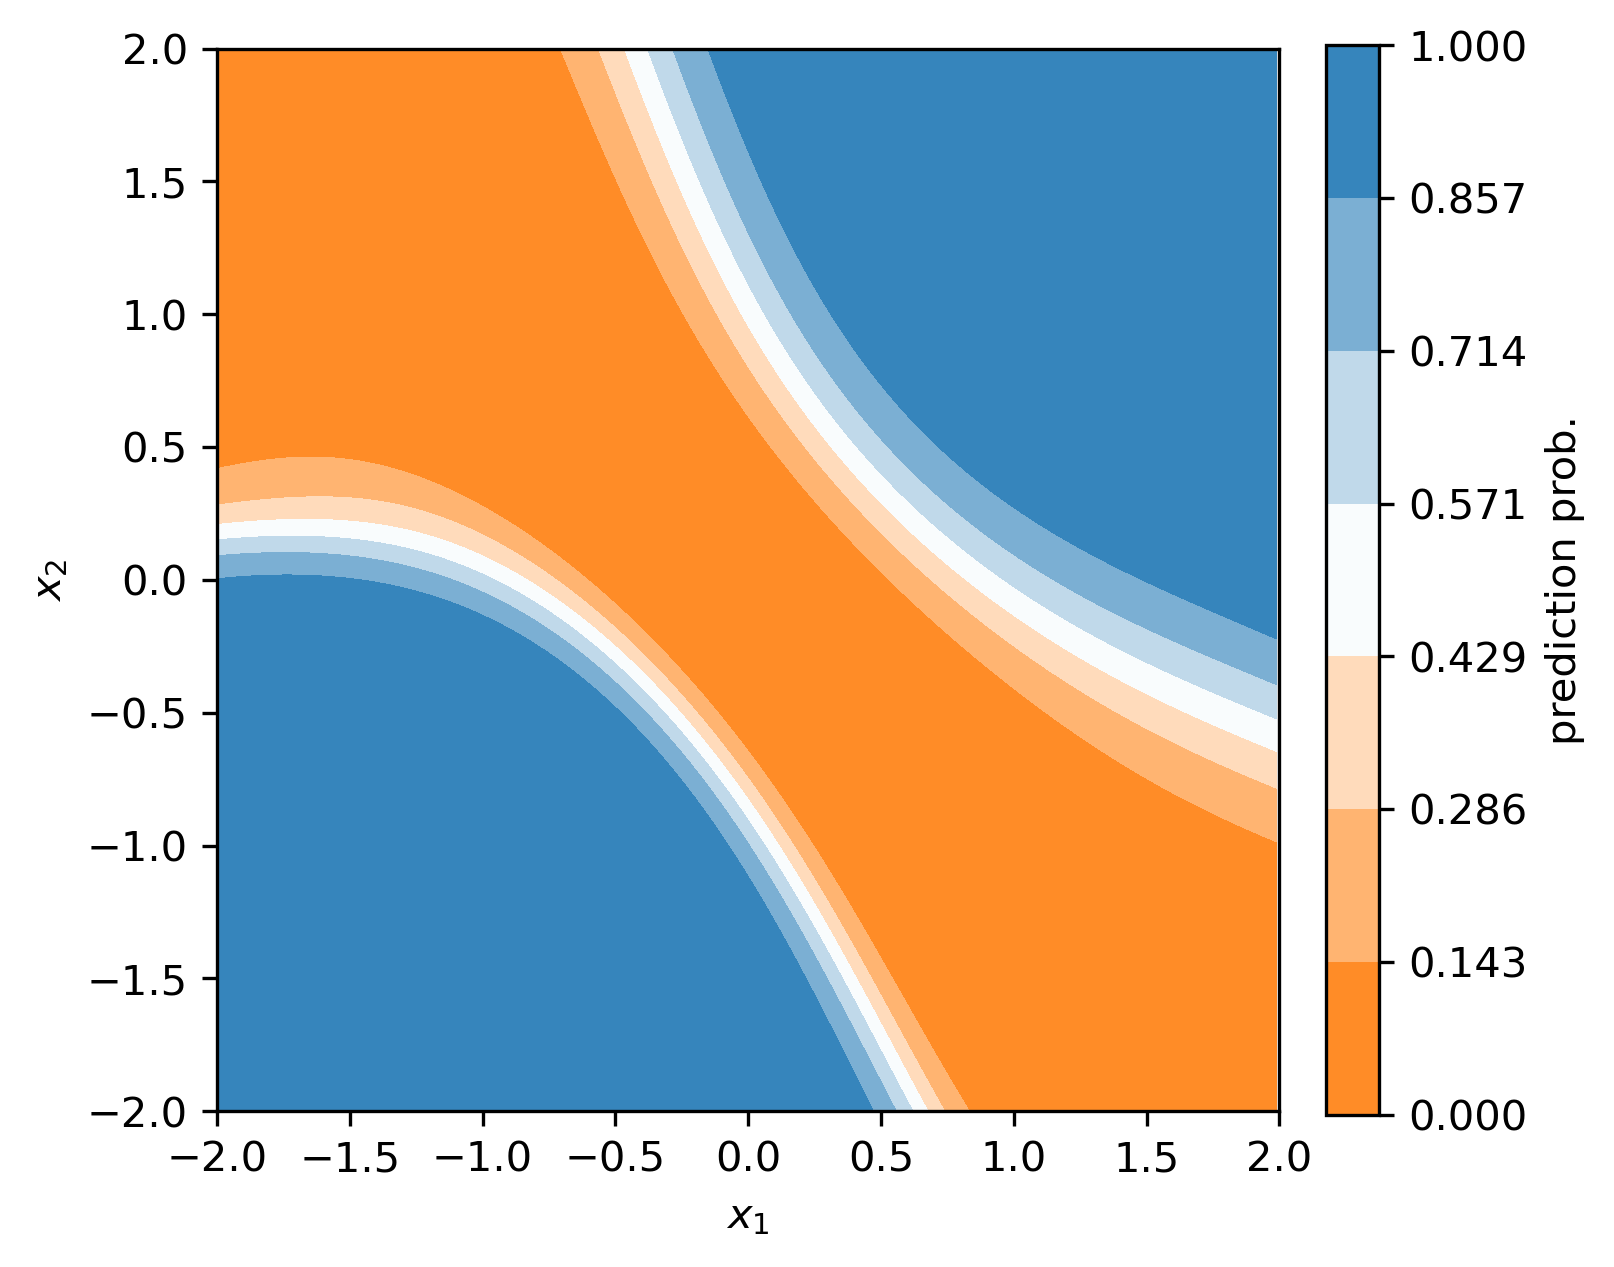

In [42]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base )
from IPython.display import Image
Image(filename = fig_name_base + '.png', width = 400)

In [43]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, eps_comp = 0) 

   
trainer_rnode.train(dataloader, num_epochs)

0.25

Iteration 0/45
Loss: 1.055
Robust Term Loss: 0.223
Accuracy: 0.547

Iteration 10/45
Loss: 1.142
Robust Term Loss: 0.221
Accuracy: 0.516

Iteration 20/45
Loss: 1.083
Robust Term Loss: 0.186
Accuracy: 0.562

Iteration 30/45
Loss: 0.990
Robust Term Loss: 0.197
Accuracy: 0.531

Iteration 40/45
Loss: 0.890
Robust Term Loss: 0.180
Accuracy: 0.531
Epoch 1: 1.071
0.25

Iteration 0/45
Loss: 0.854
Robust Term Loss: 0.168
Accuracy: 0.547

Iteration 10/45
Loss: 0.914
Robust Term Loss: 0.163
Accuracy: 0.516

Iteration 20/45
Loss: 0.896
Robust Term Loss: 0.144
Accuracy: 0.562

Iteration 30/45
Loss: 0.811
Robust Term Loss: 0.145
Accuracy: 0.531

Iteration 40/45
Loss: 0.762
Robust Term Loss: 0.129
Accuracy: 0.516
Epoch 2: 0.874
0.25

Iteration 0/45
Loss: 0.707
Robust Term Loss: 0.123
Accuracy: 0.547

Iteration 10/45
Loss: 0.748
Robust Term Loss: 0.118
Accuracy: 0.531

Iteration 20/45
Loss: 0.762
Robust Term Loss: 0.112
Accuracy: 0.547

Iteration 30/45
Loss: 0.694
Robust Term Loss: 0.110
Accuracy

In [44]:

 #number of optimization runs in which the dataset is used for gradient decent


trainer_lnode = doublebackTrainer(lnode, optimizer_lnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 
trainer_lnode.train(dataloader, num_epochs_stage1)
stage_one_histories = trainer_lnode.histories

   

trainer_lnode = doublebackTrainer(lnode, optimizer_lnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, eps_comp = 0.) 
trainer_lnode.train(dataloader, num_epochs_stage2)
stage_two_histories = trainer_lnode.histories

0.25

Iteration 0/45
Loss: 1.110
Robust Term Loss: 0.223
Accuracy: 0.547

Iteration 10/45
Loss: 1.228
Robust Term Loss: 0.221
Accuracy: 0.516

Iteration 20/45
Loss: 1.194
Robust Term Loss: 0.187
Accuracy: 0.562

Iteration 30/45
Loss: 1.055
Robust Term Loss: 0.198
Accuracy: 0.531

Iteration 40/45
Loss: 0.946
Robust Term Loss: 0.183
Accuracy: 0.531
Epoch 1: 1.144
0.25

Iteration 0/45
Loss: 0.913
Robust Term Loss: 0.170
Accuracy: 0.547

Iteration 10/45
Loss: 0.999
Robust Term Loss: 0.166
Accuracy: 0.516

Iteration 20/45
Loss: 1.003
Robust Term Loss: 0.147
Accuracy: 0.562

Iteration 30/45
Loss: 0.889
Robust Term Loss: 0.150
Accuracy: 0.531

Iteration 40/45
Loss: 0.849
Robust Term Loss: 0.134
Accuracy: 0.516
Epoch 2: 0.958
0.25

Iteration 0/45
Loss: 0.781
Robust Term Loss: 0.126
Accuracy: 0.547

Iteration 10/45
Loss: 0.840
Robust Term Loss: 0.122
Accuracy: 0.516

Iteration 20/45
Loss: 0.870
Robust Term Loss: 0.114
Accuracy: 0.547

Iteration 30/45
Loss: 0.778
Robust Term Loss: 0.115
Accuracy

In [45]:
lnode_histories = {}

for key in stage_one_histories.keys():
    lnode_histories[key] = [*stage_one_histories[key], *stage_two_histories[key]]
    
print(len(stage_one_histories['epoch_loss_history']))
print(len(stage_two_histories['epoch_loss_history']))
print(len(lnode_histories['epoch_loss_history']))

40
60
100


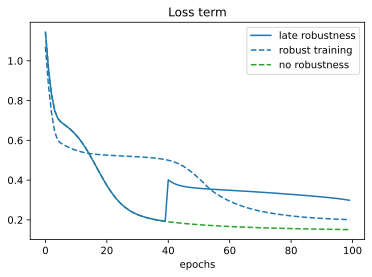

In [46]:
fig_name_base = os.path.join(subfolder, 'loss')

plt.title('Loss term')
plt.plot(lnode_histories['epoch_loss_history'], 'C0')
plt.plot(trainer_rnode.histories['epoch_loss_history'], 'C0--')
plt.plot(trainer_anode.histories['epoch_loss_history'], 'C2--', zorder = -1)
plt.legend(['late robustness', 'robust training', 'no robustness'])
plt.xlabel('epochs')
plt.savefig(fig_name_base + '_total.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()


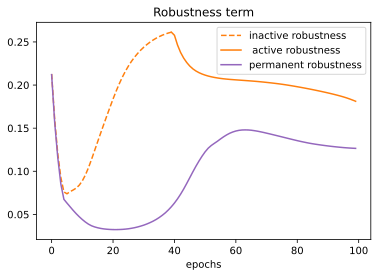

In [47]:
plt.title('Robustness term')
plt.plot(lnode_histories['epoch_loss_rob_history'][0: num_epochs_stage1], 'C1--',)
plt.plot(list(range(num_epochs_stage1 - 1 , num_epochs)),lnode_histories['epoch_loss_rob_history'][num_epochs_stage1 - 1 : num_epochs], 'C1')
plt.plot(trainer_rnode.histories['epoch_loss_rob_history'], 'C4')
plt.xlabel('epochs')
plt.legend(['inactive robustness',' active robustness', 'permanent robustness'])
plt.savefig(fig_name_base + '_robterms.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')


In [48]:
from plots.plots import classification_levelsets
if not os.path.exists(subfolder):
        os.makedirs(subfolder)


footnote = f'{num_epochs = }, {data_noise = }, {num_steps = }'
       
fig_name_base = os.path.join(subfolder, 'levelsets')
fig = classification_levelsets(anode, fig_name_base , footnote = footnote )
fig_rob = classification_levelsets(rnode, fig_name_base + '_rob', footnote = footnote)
fig_late = classification_levelsets(lnode, fig_name_base + '_late', footnote = footnote)


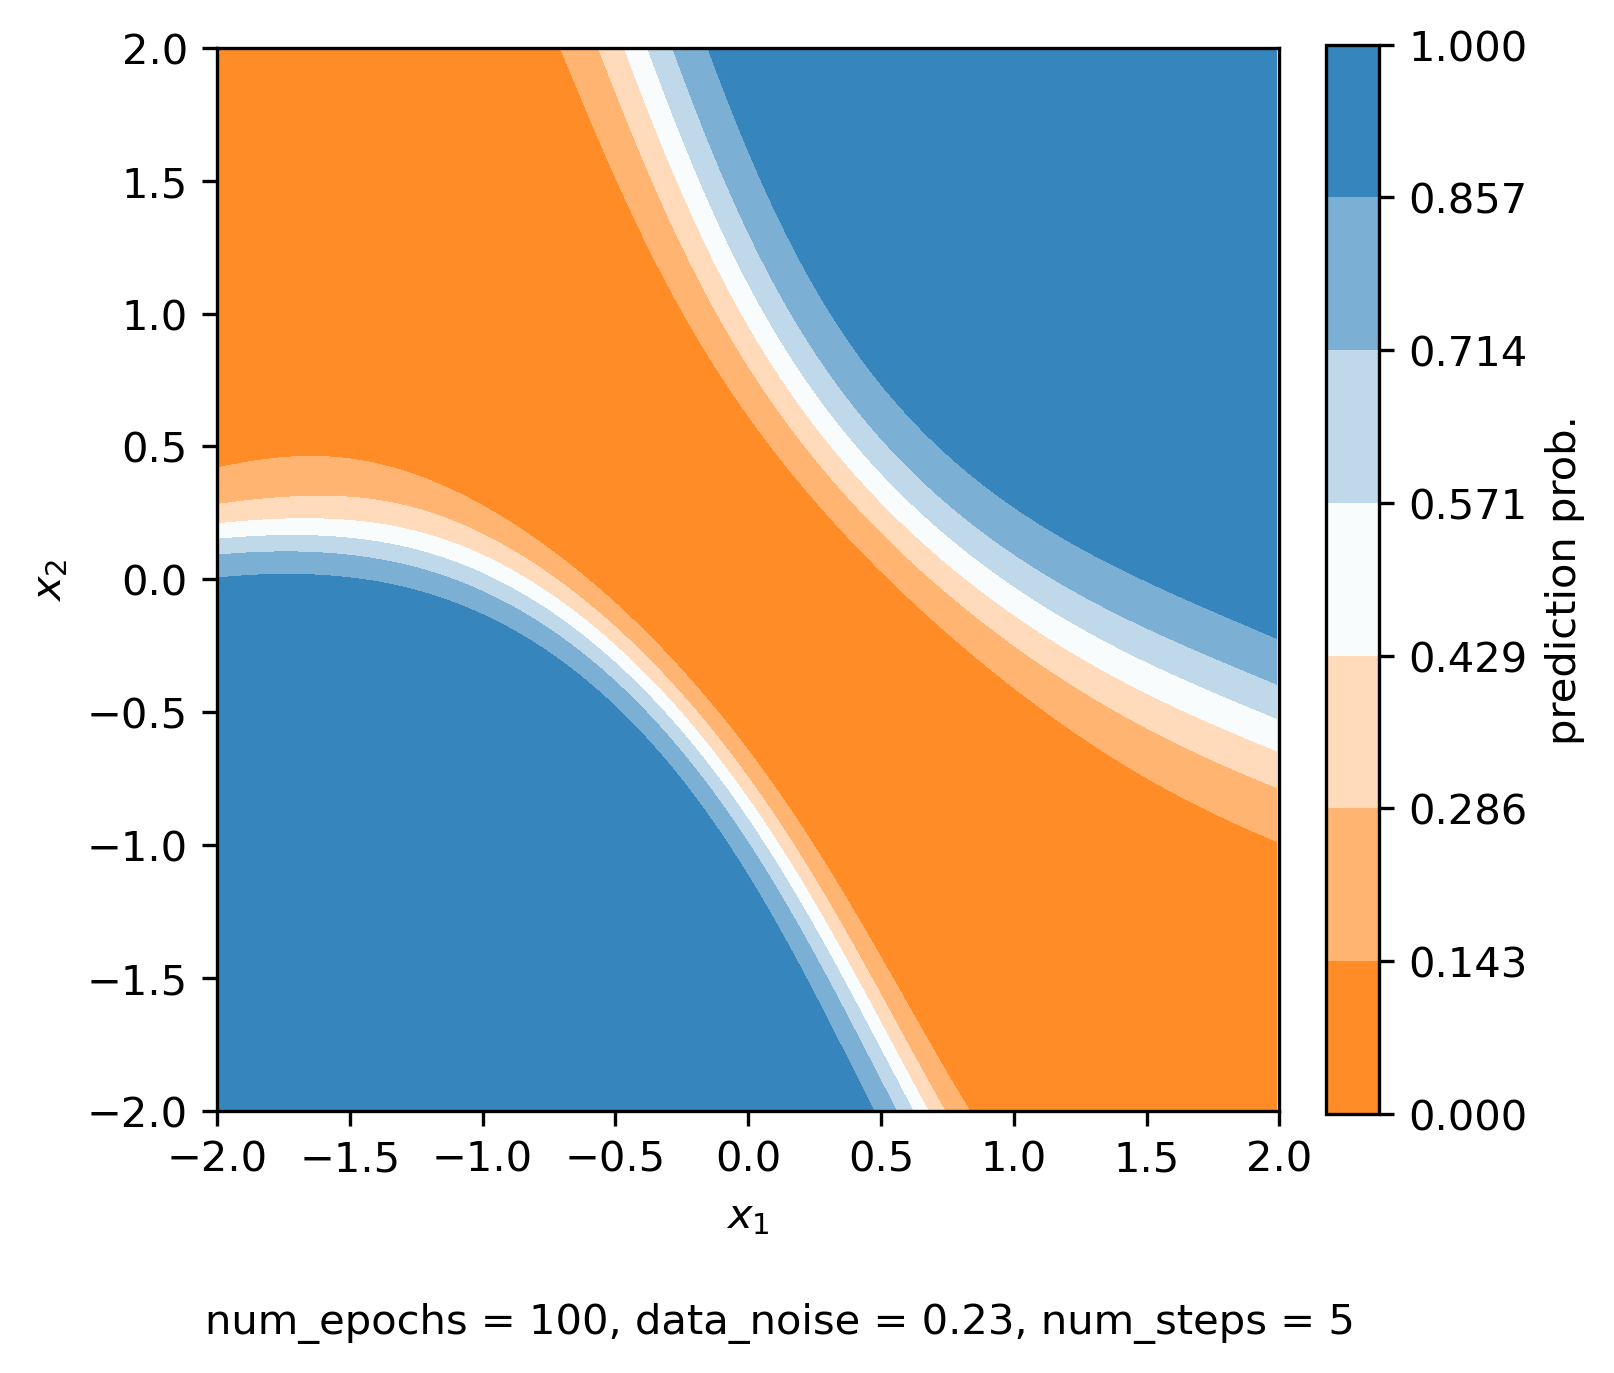

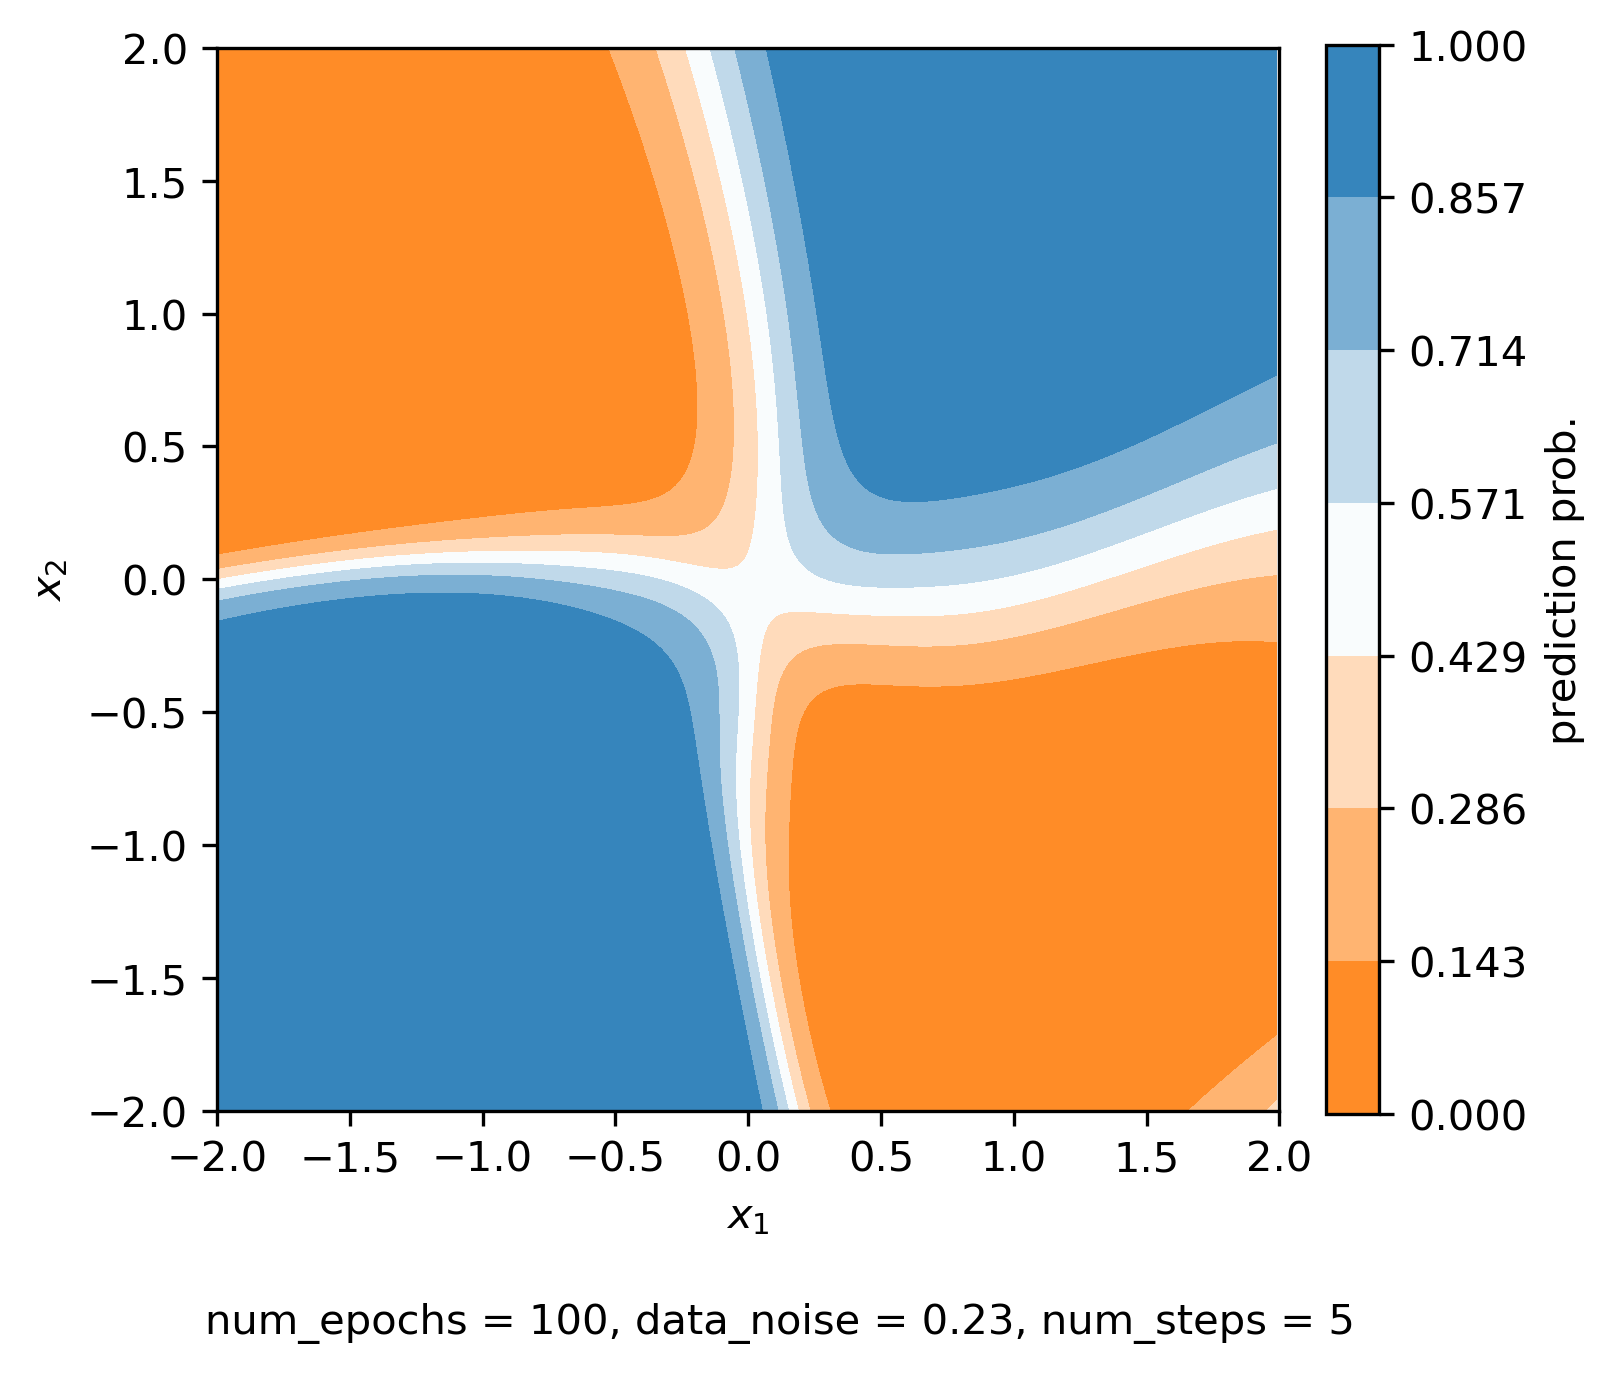

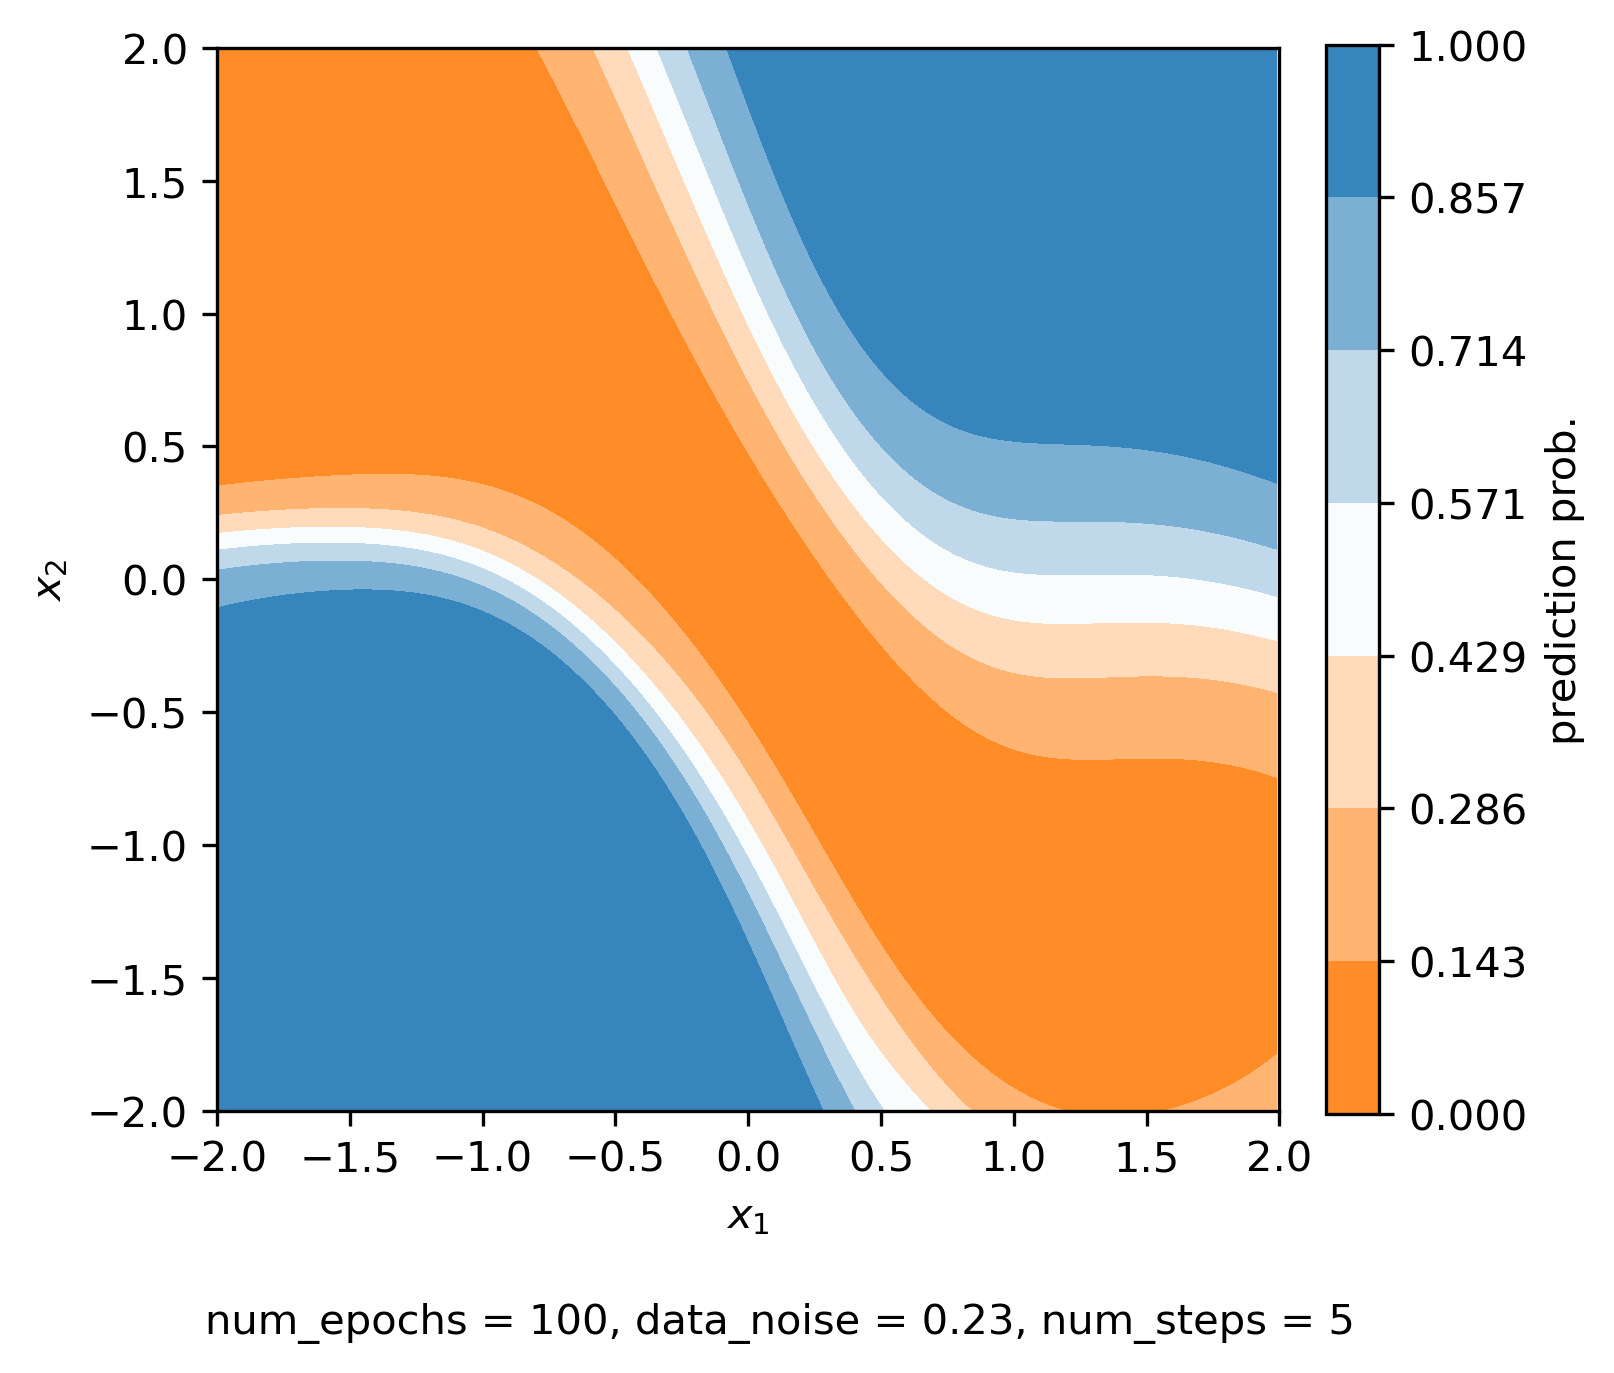

In [49]:
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)
img3 = Image(filename = fig_name_base + '_late.png', width = 400)

display(img1, img2, img3)

In [50]:
import imageio, os

def comparison_plot(fig1, title1, fig2, title2, fig3, title3, output_file, figsize = (10,3), show = False):

    fig = plt.figure(dpi = 300, figsize=figsize)
    plt.subplot(131)
    sub1 = imageio.imread(fig1)
    plt.imshow(sub1)
    plt.title(title1)
    plt.axis('off')
    plt.tight_layout()
    
    plt.subplot(132)
    sub2 = imageio.imread(fig2)
    plt.imshow(sub2)
    plt.title(title2)
    plt.axis('off')
    
    plt.subplot(133)
    sub3 = imageio.imread(fig3)
    plt.imshow(sub3)
    plt.title(title3)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
    if show: plt.show()
    else:
        plt.gca()
        plt.close()
    
    return fig

            

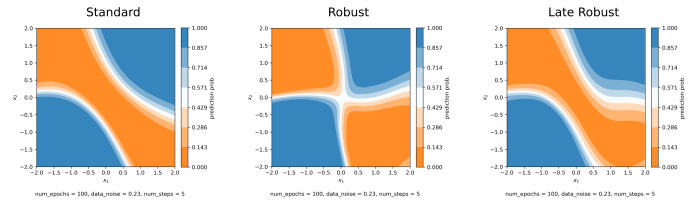

In [51]:
comparison_plot(fig_name_base + '.png', 'Standard', fig_name_base + '_rob.png', 'Robust', fig_name_base + '_late.png', 'Late Robust', fig_name_base + 'classifiers_comp.png')